In [1]:
"""
    model.ipynb
    Author: Anuvrat, Deepak, Noah
    Date: 12th August 2024
    Purpose: Experiment with various modelling techniques including LR, RF, XGB, LGBM, DT

    Github ticket: NA
"""

'\n    model.ipynb\n    Author: Anuvrat, Deepak, Noah\n    Date: 12th August 2024\n    Purpose: Experiment with various modelling techniques including LR, RF, XGB, LGBM, DT\n\n    Github ticket: NA\n'

### Importing libraries and variable definitions


In [21]:
### Import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tqdm as notebook_tqdm
import shap

import joblib

In [5]:
# Display all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Disable scientific notation
pd.options.display.float_format = "{:.2f}".format

In [6]:
# Load the data
data = pd.read_pickle("../data/BRFSS2022_modeling_data.pkl")
# data.head()

### Prepping up data: Train-Test split and Oversampling / Undersampling


In [7]:
# Train-test split
X = data.drop(columns=["CVDINFR4"])
y = data["CVDINFR4"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# Balance the training data using SMOTEENN, SMOTE and Under-sampling
sme = SMOTEENN(random_state=42, enn=EditedNearestNeighbours(sampling_strategy="all"))
sm = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_smoteenn, y_train_smoteenn = sme.fit_resample(X_train_raw, y_train_raw)
X_train_smote, y_train_smote = sm.fit_resample(X_train_raw, y_train_raw)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train_raw, y_train_raw)

#### Tried all sampling techniques and found that they gives similar results


In [9]:
# Keep only 10% of the training data for to check the model execution and performance
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_undersample, y_train_undersample, test_size=0.5, random_state=42
)

In [10]:
# Define scaler to scale the data
scaler = StandardScaler()

In [11]:
# Scale Training and Testing Data. Fit transform separately to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.fit_transform(X_test_raw)
X_train_undersample_scaled = scaler.fit_transform(X_train_undersample)

Using unscaled data. As it was giving better performance. Only BMI (and Height & Weight) are at a different scale compared to rest of the data. Try min-max scaling too.


In [12]:
# Assigning Train and Test data
X_train = X_train_sample  # X_train_sample #X_train_scaled
y_train = y_train_sample
X_test = X_test_raw  # X_test_raw #X_test_scaled
y_test = y_test_raw

In [13]:
# Checking the shape of the data
print(
    f"Train Shape={X_train.shape} \tTest shape={X_test.shape} \
      \n1s in train={y_train.sum():,}, \t%1s in train={y_train.sum() / len(y_train):0.1%} \
       \n1s in test={y_test.sum():,}, \t%1s in test={y_test.sum() / len(y_test):0.1%}"
)

Train Shape=(8182, 68) 	Test shape=(37781, 68)       
1s in train=4,076.0, 	%1s in train=49.8%        
1s in test=1,944.0, 	%1s in test=5.1%


## Modeling


### Logistic Regression


#### Grid Search


In [14]:
# Create the parameter grid search
param_grid = [
    {"solver": ["liblinear"], "penalty": ["l1"], "C": [1e-6], "max_iter": [int(1e6)]},
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"],
        "penalty": ["l2"],
        "max_iter": [100, 200, 500],
        "C": [0.01, 0.1, 1],
    },
]

# Create a base model
clf_logistic = LogisticRegression()

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the grid search model with precision as the scoring function
grid_search_lr = GridSearchCV(
    estimator=clf_logistic,
    param_grid=param_grid,
    scoring=precision_scorer,
    cv=2,
    n_jobs=-1,
    verbose=5,
)

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)
print("Best parameters found: ", grid_search_lr.best_params_)

Fitting 2 folds for each of 28 candidates, totalling 56 fits
Best parameters found:  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     35837
         1.0       0.21      0.77      0.33      1944

    accuracy                           0.84     37781
   macro avg       0.60      0.81      0.62     37781
weighted avg       0.95      0.84      0.88     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30141,5696
Actual 1,446,1498


Accuracy: 0.8374315131944629
Precision: 0.20822907978871283
Recall: 0.7705761316872428


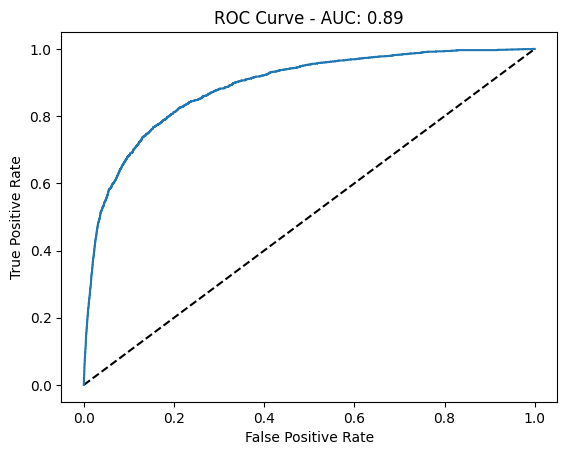

In [15]:
# Predict the test set using the best model
y_pred = grid_search_lr.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(
    pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search_lr.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

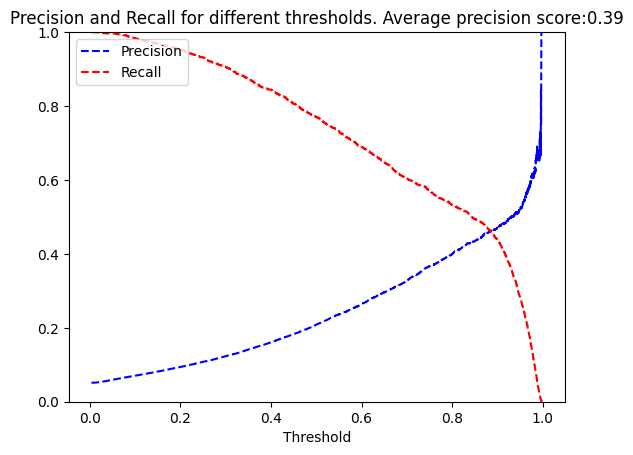

In [14]:
# Printing precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title(
    f"Precision and Recall for different thresholds. Average precision score:{average_precision_score(y_test, y_pred_prob):0.2f}"
)
plt.ylim([0, 1])
plt.show()



Best estimator:LogisticRegression(C=1, solver='newton-cg')


Best parameters:{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Best score:0.8274777843165069


Best index:19


Best average score:[0.         0.79119644 0.71581637 0.79206981 0.79119644 0.76629762
 0.79206981 0.79119644 0.76814058 0.79206981 0.82402559 0.71744811
 0.82333123 0.82402559 0.73552075 0.82333123 0.82402559 0.77689642
 0.82333123 0.82747778 0.71877057 0.82662841 0.82747778 0.72769532
 0.82662841 0.82747778 0.78486196 0.82662841]


Best results:{'mean_fit_time': array([0.031322  , 1.1826514 , 0.13628018, 0.31756878, 1.2464174 ,
       0.30162621, 0.27171814, 1.49071372, 0.79256558, 0.32778525,
       1.96750808, 0.17358804, 0.66434872, 2.01103544, 0.28848684,
       0.52344489, 1.97550488, 0.78174007, 0.51824749, 2.21714449,
       0.1408534 , 0.51928568, 2.16293943, 0.25051939, 0.58070087,
       1.70837867, 0.78689206, 0.44813967]), 'std_fit_time': array([0.00476956, 0.00931752, 0.0120486 , 

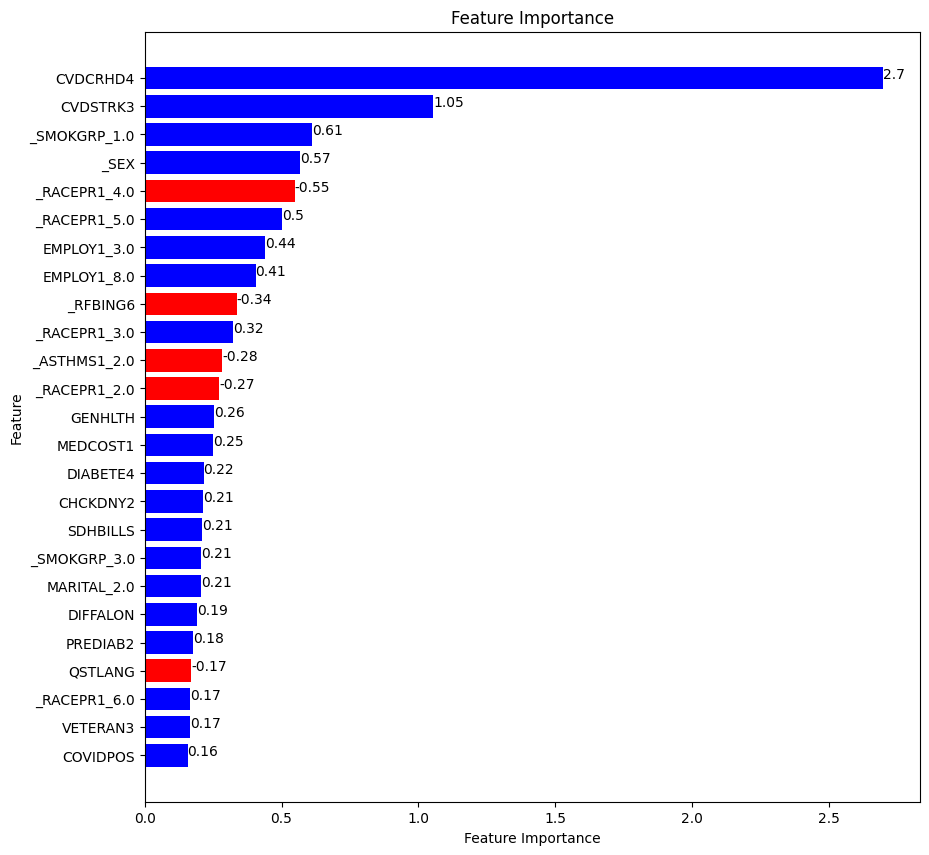

In [15]:
# Print the best model
print(f"\n\nBest estimator:{grid_search_lr.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search_lr.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search_lr.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search_lr.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search_lr.cv_results_['mean_test_score']}")

# Print the results
print(f"\n\nBest results:{grid_search_lr.cv_results_}")

# Count the number of features with negative coefficients
negative_coefficients = sum(grid_search_lr.best_estimator_.coef_[0] < 0)
print(f"\n\nNumber of features with negative coefficients: {negative_coefficients}")

# Plot feature importance
feature_importance = dict(
    zip(
        X.columns,
        zip(
            np.abs(grid_search_lr.best_estimator_.coef_[0]),
            np.where(grid_search_lr.best_estimator_.coef_[0] >= 0, 1, -1),
        ),
    )
)
sorted_features = sorted(
    feature_importance.items(), key=lambda x: x[1][0], reverse=False
)
print("\n\nFeature importance:")
for feature in sorted_features:
    print(feature)

# Plot feature importance with feature importance values as data labels
plt.figure(figsize=(10, 10))
top_n = 25
colors = ["blue" if x[1][1] == 1 else "red" for x in sorted_features[-top_n:]]
plt.barh(
    [x[0] for x in sorted_features[-top_n:]],
    [x[1][0] for x in sorted_features[-top_n:]],
    color=colors,
)
for index, value in enumerate([x[1] for x in sorted_features[-top_n:]]):
    plt.text(value[0], index, str(value[1] * round(value[0], 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

(array([10921.,  7351.,  5323.,  4059.,  2978.,  2102.,  1468.,   993.,
          768.,  1818.]),
 array([0.00328002, 0.10290186, 0.20252371, 0.30214555, 0.40176739,
        0.50138923, 0.60101108, 0.70063292, 0.80025476, 0.89987661,
        0.99949845]),
 <BarContainer object of 10 artists>)

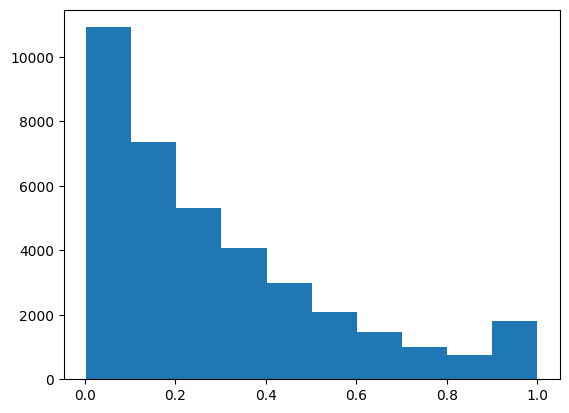

In [16]:
y_probs = grid_search_lr.best_estimator_.predict_proba(X_test)[:, 1]

# Create a histogram of the probabilities
plt.hist(y_probs, bins=10)

#### Specific LR Models


Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     35837
         1.0       0.21      0.77      0.33      1944

    accuracy                           0.84     37781
   macro avg       0.60      0.81      0.62     37781
weighted avg       0.95      0.84      0.88     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30141,5696
Actual 1,446,1498


Accuracy: 0.8374315131944629
Precision: 0.20822907978871283
Recall: 0.7705761316872428


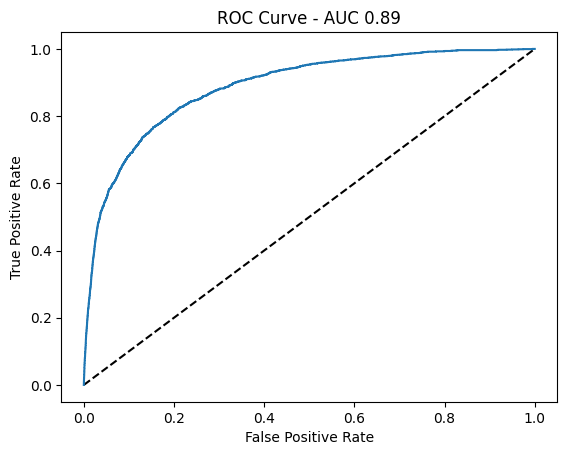

In [17]:
# Create an LR model
clf_logistic = LogisticRegression(solver="liblinear", penalty="l1", C=0.1)
# Best parameters:{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
clf_logistic = LogisticRegression(solver="newton-cg", penalty="l2", C=1, max_iter=100)

# Fit the grid search to the data
clf_logistic.fit(X_train, y_train)

# Predict the test set using the LR model
y_pred = clf_logistic.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(
    pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = clf_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

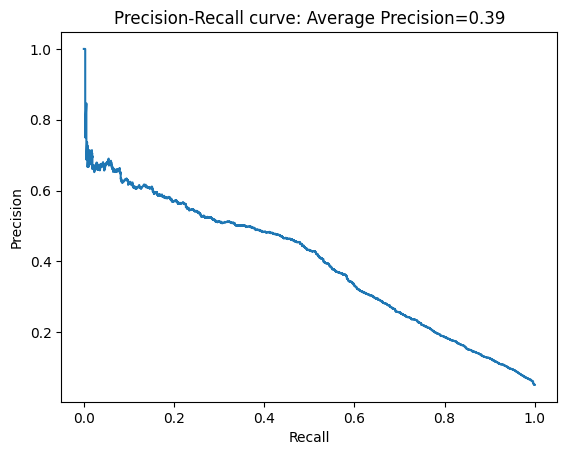

In [18]:
# Plot PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve: Average Precision={average_precision:0.2f}")
plt.show()

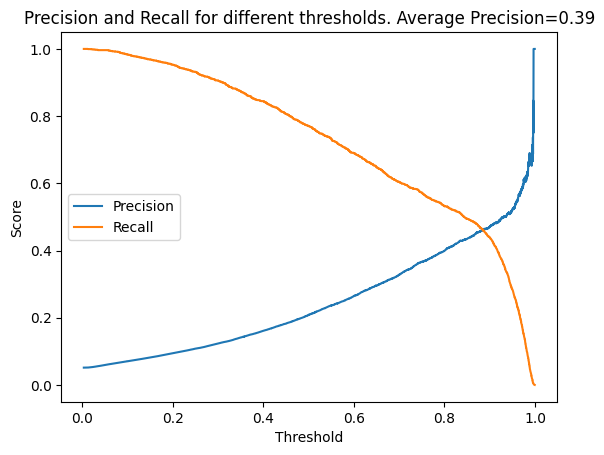

In [19]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(
    f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}"
)
plt.show()

In [20]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = thresholds.max()
    else:
        threshold = np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold:0.2f}, Precision: {precision_threshold:0.2f}, Recall: {recall_threshold:0.2f}"
    )

Threshold: 0.00, Precision: 0.05, Recall: 1.00
Threshold: 0.10, Precision: 0.07, Recall: 0.98
Threshold: 0.20, Precision: 0.09, Recall: 0.95
Threshold: 0.30, Precision: 0.12, Recall: 0.91
Threshold: 0.40, Precision: 0.16, Recall: 0.84
Threshold: 0.50, Precision: 0.21, Recall: 0.77
Threshold: 0.60, Precision: 0.26, Recall: 0.69
Threshold: 0.70, Precision: 0.33, Recall: 0.60
Threshold: 0.80, Precision: 0.40, Recall: 0.53
Threshold: 0.90, Precision: 0.47, Recall: 0.44
Threshold: 1.00, Precision: 1.00, Recall: 0.00


### Random Forest


#### Random Search


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
RandomForestClassifier(max_features='log2', min_samples_leaf=4,
                       n_estimators=1600)
0.8075043615472658
19
[0.80457132 0.80640452 0.80554879 0.80628242 0.8042047  0.80616037
 0.80542682 0.80579335 0.80677136 0.80628229 0.80664935 0.805427
 0.80542664 0.80616019 0.80652698 0.80640461 0.80603804 0.80408225
 0.80530463 0.80750436]
{'mean_fit_time': array([ 1.56905071,  6.19554599,  6.12619122, 12.76454091,  9.55403829,
        4.62387053, 20.41654174,  1.23385382,  7.81440481, 15.47162517,
        3.58972891, 10.89592806,  9.49112638, 13.80633148, 17.71592887,
       10.17433715,  8.4395868 ,  5.10455267, 18.23453546, 11.36775605]), 'std_fit_time': array([0.05852335, 0.04642349, 0.00614041, 0.1538539 , 0.0187749 ,
       0.18468461, 0.31008866, 0.01004957, 0.02664099, 0.24282165,
       0.09545477, 0.26027656, 0.28098264, 0.08244275, 0.19

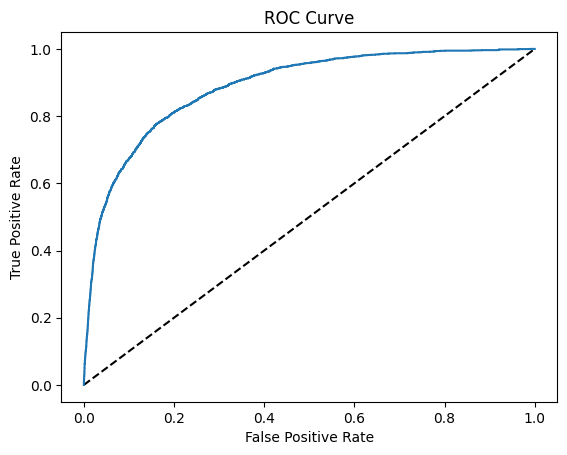

AUC: 0.8879706940122464


In [21]:
# Perform random search for hyperparameter tuning using random forest classifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["log2", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_random_forest = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
random_search_rf = RandomizedSearchCV(
    estimator=clf_random_forest,
    param_distributions=random_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# Fit the random search model
random_search_rf.fit(X_train, y_train)

# Print the best parameters
print(random_search_rf.best_params_)
# Print the best model
print(random_search_rf.best_estimator_)
# Print the best score
print(random_search_rf.best_score_)
# Print the best index
print(random_search_rf.best_index_)
# Print average score
print(random_search_rf.cv_results_["mean_test_score"])
# Print the results
print(random_search_rf.cv_results_)
# Print feature importance
feature_importance = dict(
    zip(X.columns, random_search_rf.best_estimator_.feature_importances_)
)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature in sorted_features:
    print(feature)

# Predict the test set using the best model
y_pred = random_search_rf.best_estimator_.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = random_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

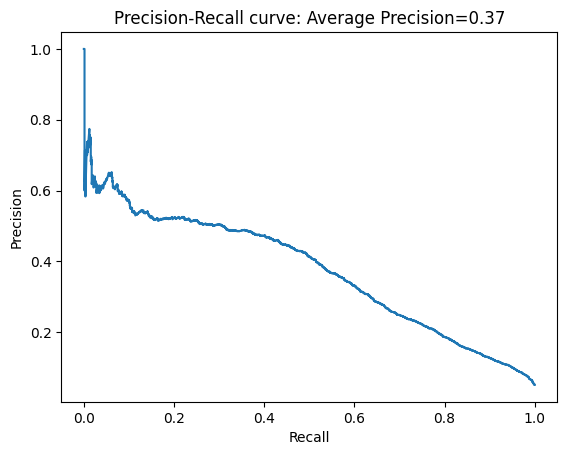

In [22]:
# Plot PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve: Average Precision={average_precision:0.2f}")
plt.show()

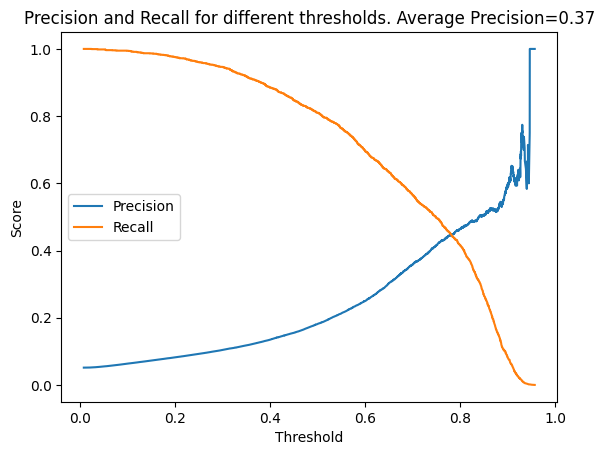

In [23]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(
    f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}"
)
plt.show()

In [24]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = thresholds.max()
    else:
        threshold = np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold:0.2f}, Precision: {precision_threshold:0.2f}, Recall: {recall_threshold:0.2f}"
    )

Threshold: 0.00, Precision: 0.05, Recall: 1.00
Threshold: 0.10, Precision: 0.06, Recall: 0.99
Threshold: 0.20, Precision: 0.08, Recall: 0.98
Threshold: 0.30, Precision: 0.10, Recall: 0.95
Threshold: 0.40, Precision: 0.13, Recall: 0.88
Threshold: 0.50, Precision: 0.18, Recall: 0.81
Threshold: 0.60, Precision: 0.25, Recall: 0.69
Threshold: 0.70, Precision: 0.36, Recall: 0.56
Threshold: 0.80, Precision: 0.46, Recall: 0.42
Threshold: 0.90, Precision: 0.59, Recall: 0.08
Threshold: 0.96, Precision: 1.00, Recall: 0.00


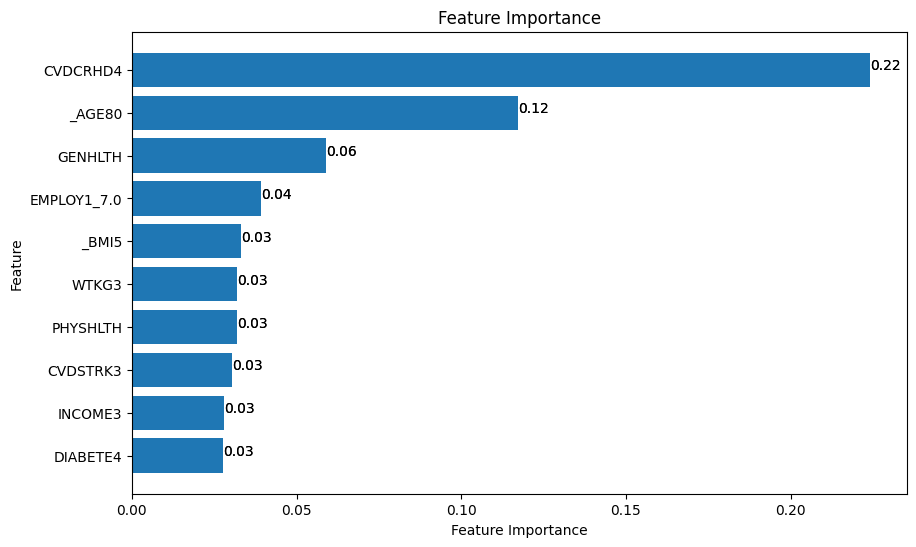

In [25]:
# Feature importance plot with feature importance values as data labels
sorted_features_reverse = sorted(
    feature_importance.items(), key=lambda x: x[1], reverse=False
)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features_reverse[-10:]],
    [x[1] for x in sorted_features_reverse[-10:]],
)

for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))

# Add feature imporatance values ad data labels to the plot
for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))


plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

(array([7547., 6995., 5206., 4659., 4058., 3220., 2510., 1480., 1265.,
         841.]),
 array([0.00776675, 0.10263382, 0.19750088, 0.29236794, 0.38723501,
        0.48210207, 0.57696913, 0.67183619, 0.76670326, 0.86157032,
        0.95643738]),
 <BarContainer object of 10 artists>)

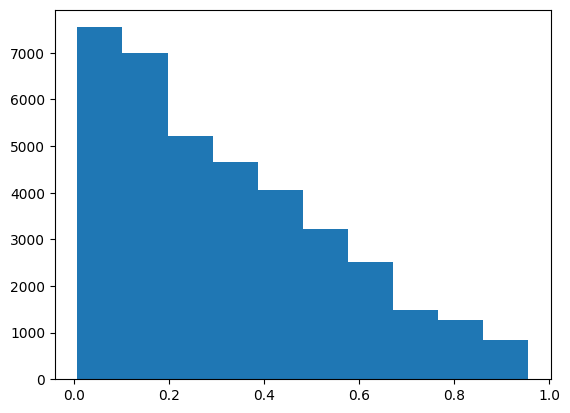

In [26]:
y_probs = random_search_rf.best_estimator_.predict_proba(X_test)[:, 1]

# Create a histogram of the probabilities
plt.hist(y_probs, bins=10)

#### Shapley Analysis


Shapley Analysis explainer takes nearly an hour to run. Please comment Shapley section out if you are in a hurry.

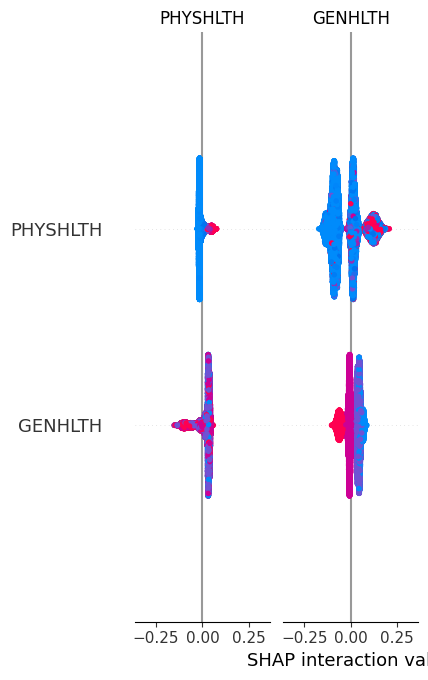

In [27]:
# Shapley analysis with values and plot
#shap.initjs()
#explainer = shap.TreeExplainer(random_search_rf.best_estimator_)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, plot_type="bar")

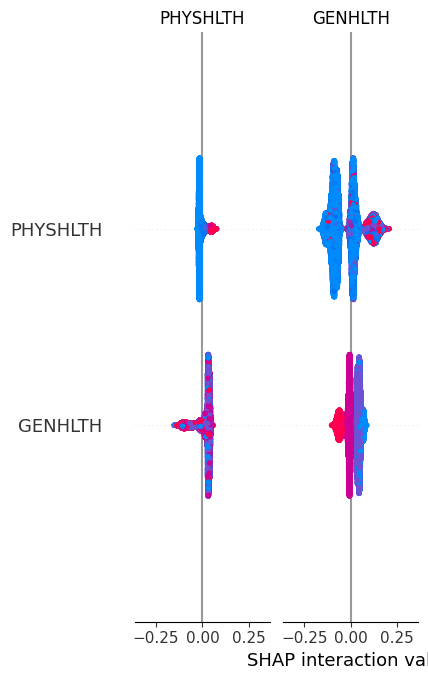

In [28]:
# Shapley plot with feature names and values as data labels
#shap.summary_plot(shap_values, X_test, feature_names=X.columns) #plot_type="bar"

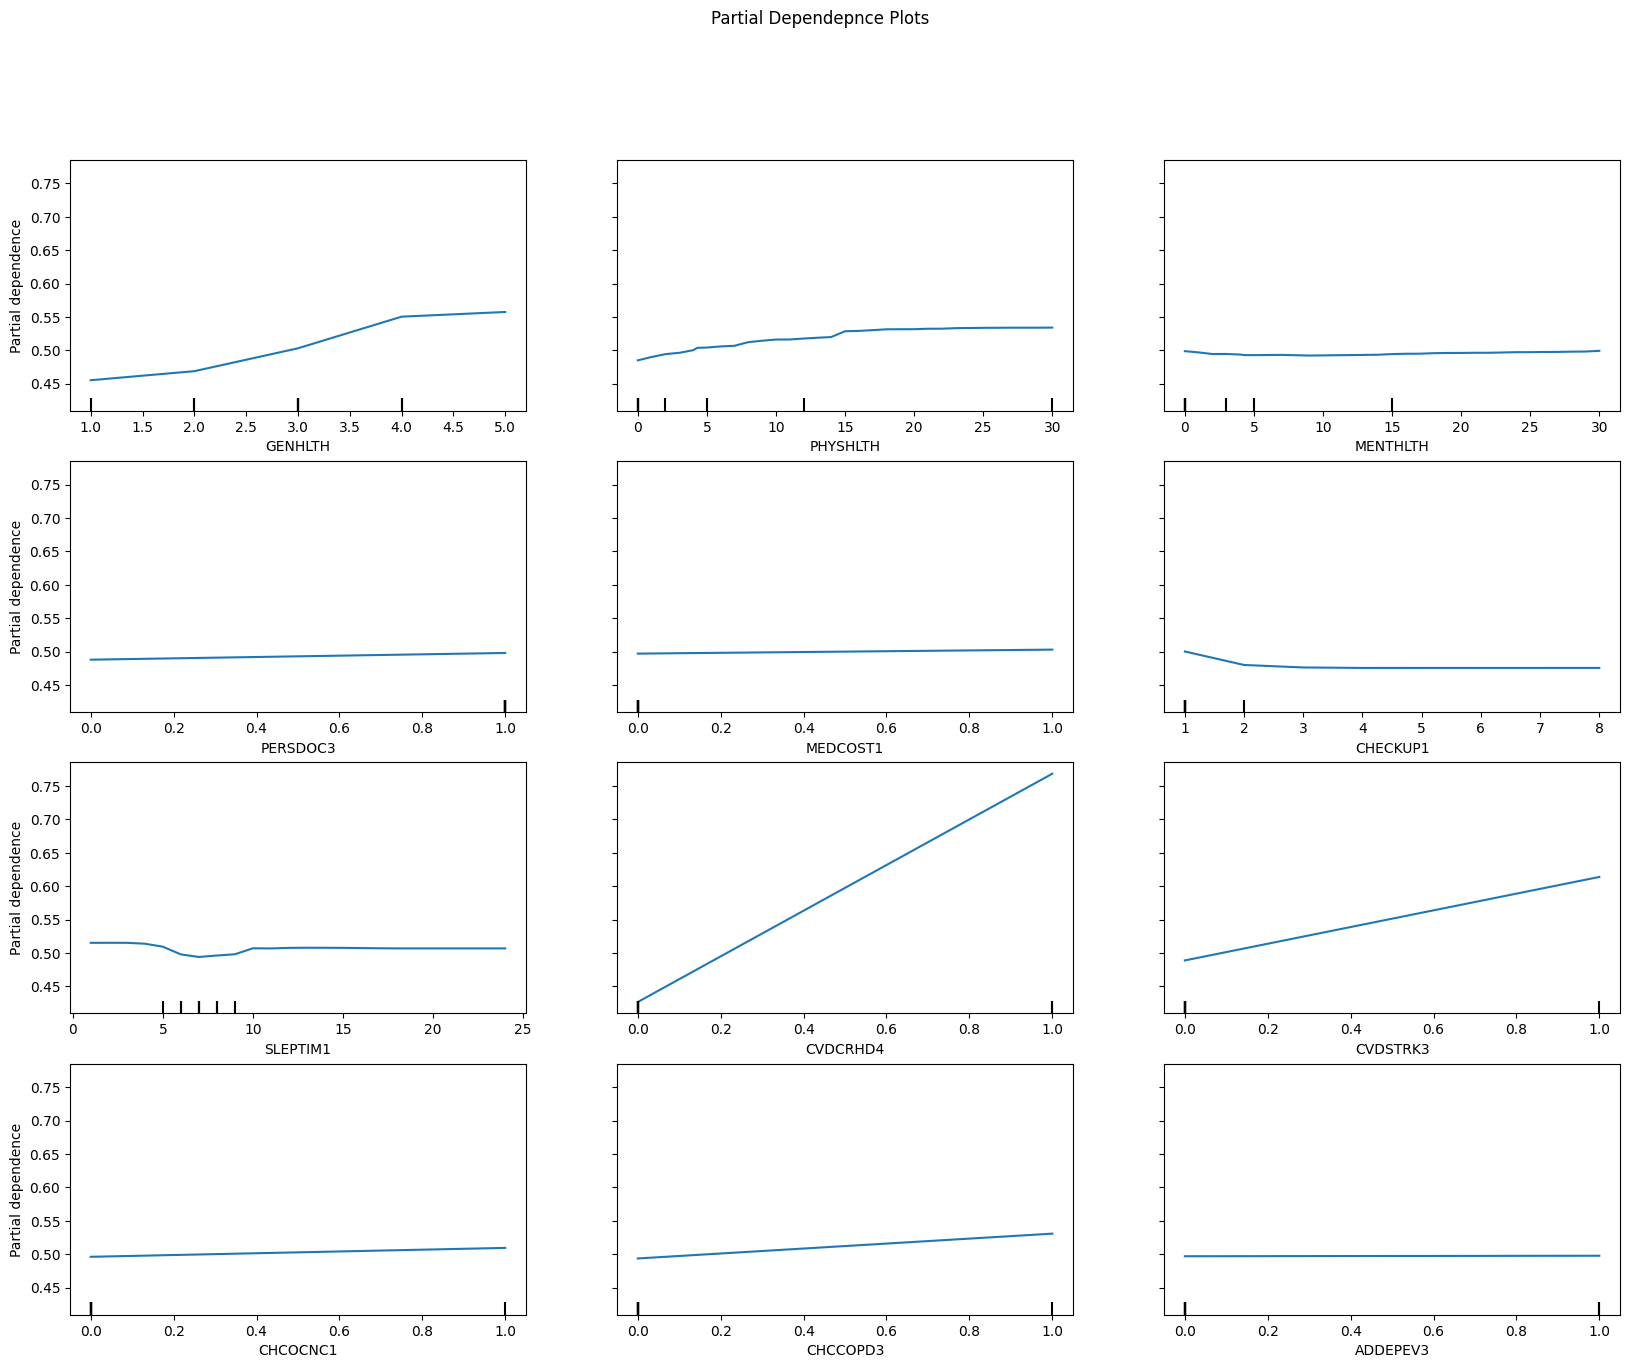

In [29]:
# Partial dependence plot
# Set figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plot partial dependence on figure using the updated method
PartialDependenceDisplay.from_estimator(
    estimator=random_search_rf.best_estimator_,
    X=X_train,
    features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    feature_names=X.columns,
    grid_resolution=50,
    ax=ax,
)

plt.suptitle("Partial Dependepnce Plots")
plt.show()

### XGBoost


#### Random Search


In [30]:
# Create an XGBClassifier using the best parameters from the random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [1, 2, 4]
# Minimum number of samples required at each leaf node
gamma = [0.1, 0.2, 0.3]
# Learning rate
learning_rate = [0.01, 0.1, 0.2]
# Create the parameter grid
param_grid_xgb = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate,
}

# Create a base model
clf_xgb = XGBClassifier(reg_alpha=0.002, colsample_bytree=0.8)

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the random search model with precision as the scoring function
random_search_xgb = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=precision_scorer,
)

# Fit the grid search to the data
random_search_xgb.fit(X_train, y_train)
print("Best parameters found: ", random_search_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     35837
         1.0       0.21      0.77      0.33      1944

    accuracy                           0.84     37781
   macro avg       0.60      0.81      0.62     37781
weighted avg       0.95      0.84      0.88     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30198,5639
Actual 1,446,1498


Accuracy: 0.8389402080410788
Precision: 0.2098921115314558
Recall: 0.7705761316872428


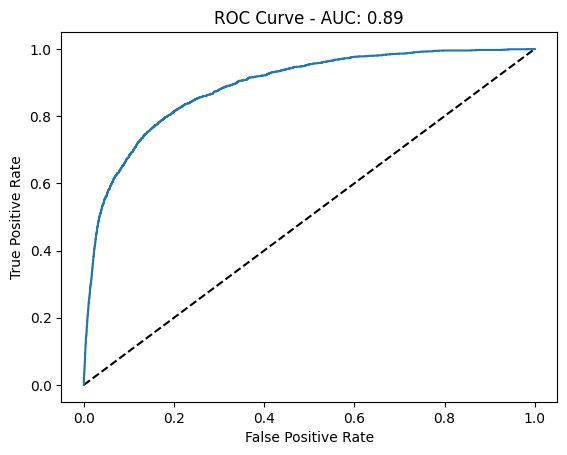

AUC: 0.8882843426529655


Best estimator:XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=480, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Best parameters:{'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Best score:0.8318923229256264


Best index:14


Best average score:[0.80303941 0.79954233 0.80

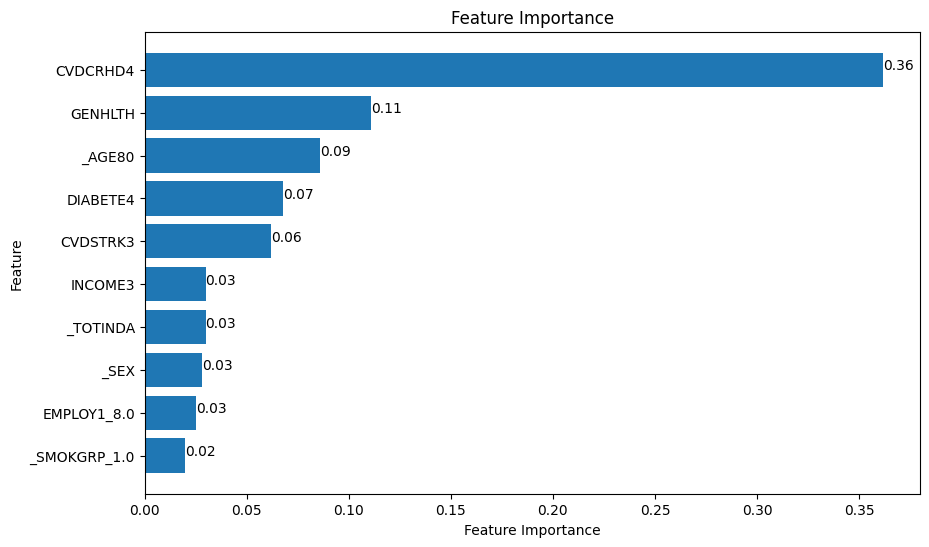

In [31]:
# Predict the test set using the best model
y_pred = random_search_xgb.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(
    pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = random_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{random_search_xgb.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{random_search_xgb.best_params_}")

# Print the best score
print(f"\n\nBest score:{random_search_xgb.best_score_}")

# Print the best index
print(f"\n\nBest index:{random_search_xgb.best_index_}")

# Print average score
print(f"\n\nBest average score:{random_search_xgb.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{random_search_xgb.cv_results_}")

# Plot Feature Importance
feature_importance = dict(
    zip(X.columns, random_search_xgb.best_estimator_.feature_importances_)
)

# Plot feature importance with feature importance values as data labels
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

(array([10694.,  7172.,  5524.,  4185.,  3158.,  2207.,  1441.,   914.,
          771.,  1715.]),
 array([0.00836123, 0.10736231, 0.20636338, 0.30536446, 0.40436554,
        0.50336665, 0.6023677 , 0.70136881, 0.80036986, 0.89937091,
        0.99837202]),
 <BarContainer object of 10 artists>)

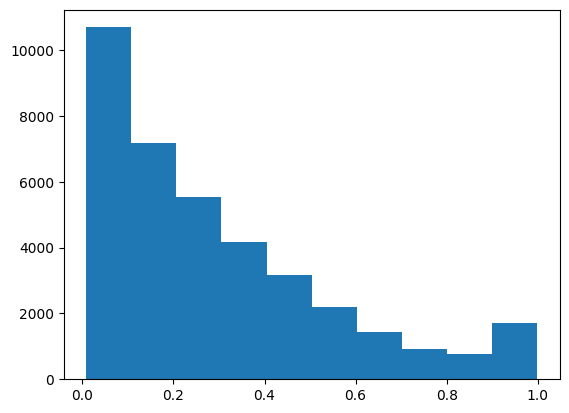

In [32]:
y_probs = random_search_xgb.predict_proba(X_test)[:, 1]

# Create a histogram of the probabilities
plt.hist(y_probs, bins=10)

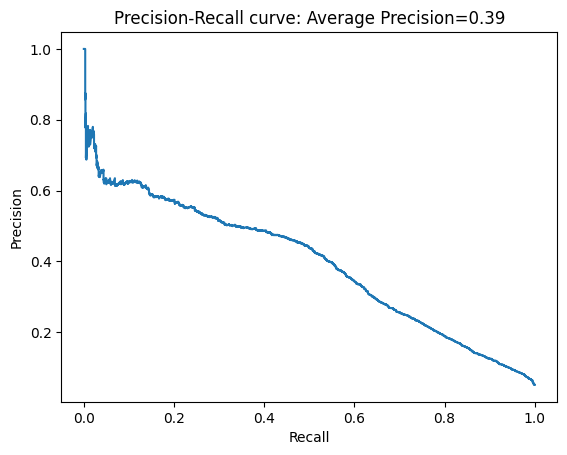

In [33]:
# Plot PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve: Average Precision={average_precision:0.2f}")
plt.show()

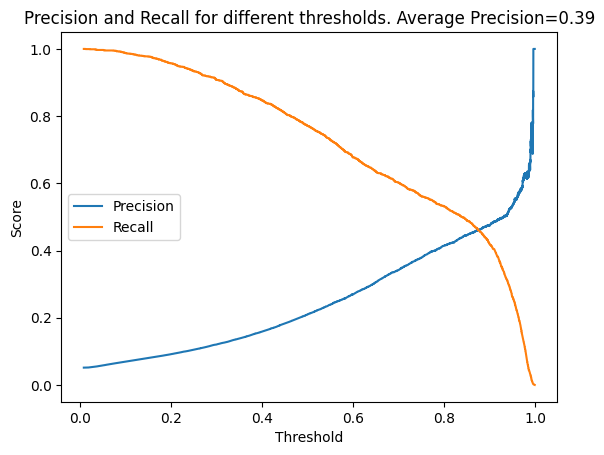

In [34]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(
    f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}"
)
plt.show()

In [35]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = thresholds.max()
    else:
        threshold = np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold:0.2f}, Precision: {precision_threshold:0.2f}, Recall: {recall_threshold:0.2f}"
    )

Threshold: 0.00, Precision: 0.05, Recall: 1.00
Threshold: 0.10, Precision: 0.07, Recall: 0.99
Threshold: 0.20, Precision: 0.09, Recall: 0.96
Threshold: 0.30, Precision: 0.12, Recall: 0.91
Threshold: 0.40, Precision: 0.16, Recall: 0.85
Threshold: 0.50, Precision: 0.21, Recall: 0.77
Threshold: 0.60, Precision: 0.27, Recall: 0.68
Threshold: 0.70, Precision: 0.34, Recall: 0.60
Threshold: 0.80, Precision: 0.41, Recall: 0.53
Threshold: 0.90, Precision: 0.47, Recall: 0.42
Threshold: 1.00, Precision: 1.00, Recall: 0.00


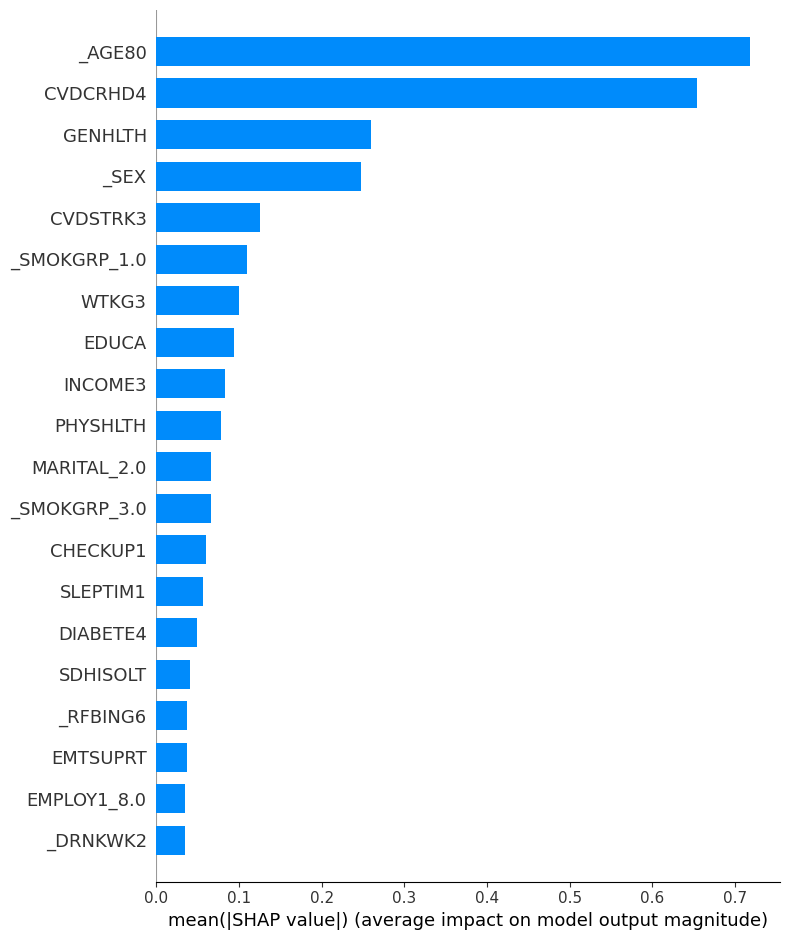

In [36]:
# Shapley analysis with values and plot
shap.initjs()
explainer = shap.TreeExplainer(random_search_xgb.best_estimator_)
shap_values_xgb = explainer.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

### LGBM


#### Random Search


In [37]:
# Create an LGBMClassifier using the best parameters from the random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [1, 2, 4]
# Minimum number of samples required at each leaf node
gamma = [0.1, 0.2, 0.3]
# Learning rate
learning_rate = [0.01, 0.1, 0.2]
# Create the parameter grid
param_grid_lgb = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate,
}
# Add other parameters to the parameter grid added on top of XGBoost paraemeters
param_grid_lgb.update(
    {
        # Add other parameters here
        "colsample_bytree": [0.6, 0.7, 0.8],
        "subsample": [0.6, 0.7, 0.8],
        "reg_alpha": [0.001, 0.01, 0.1],
        "reg_lambda": [0.001, 0.01, 0.1],
    }
)

# Create a base model
clf_lgb = lgb.LGBMClassifier(objective="binary", reg_alpha=0.002)

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the random search model with precision as the scoring function
random_search_lgb = RandomizedSearchCV(
    estimator=clf_lgb,
    param_distributions=param_grid_lgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=precision_scorer,
)

# Fit the grid search to the data
random_search_lgb.fit(X_train, y_train)
print("Best parameters found: ", random_search_lgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
Best parameters found:  {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 280, 'min_child_weight': 2, 'max_depth': 45, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


[LightGBM] [Warning] Unknown parameter: gamma
Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     35837
         1.0       0.19      0.79      0.31      1944

    accuracy                           0.82     37781
   macro avg       0.59      0.80      0.60     37781
weighted avg       0.95      0.82      0.87     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,29381,6456
Actual 1,409,1535


Accuracy: 0.8182949101400174
Precision: 0.1920911024903016
Recall: 0.7896090534979424
[LightGBM] [Warning] Unknown parameter: gamma


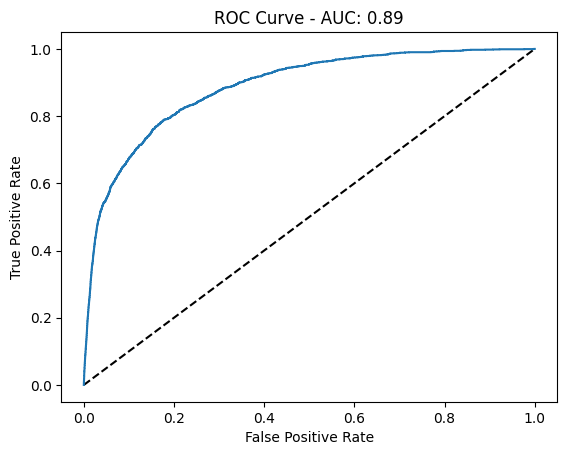

AUC: 0.8862209233025939


Best estimator:LGBMClassifier(colsample_bytree=0.8, gamma=0.1, learning_rate=0.01,
               max_depth=45, min_child_weight=2, n_estimators=280,
               objective='binary', reg_alpha=0.1, reg_lambda=0.01,
               subsample=0.7)


Best parameters:{'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 280, 'min_child_weight': 2, 'max_depth': 45, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


Best score:0.8131854055433716


Best index:19


Best average score:[0.78719885 0.79290725 0.80518795 0.7852984  0.78943071 0.80197555
 0.79052984 0.78976216 0.78883101 0.78912186 0.78837343 0.81263905
 0.80856378 0.80550562 0.80638794 0.78736268 0.78530025 0.81017799
 0.80863027 0.81318541]


Best results:{'mean_fit_time': array([ 9.62251933,  7.83696953, 10.4573818 ,  8.35797103,  8.33573341,
        2.85841195,  8.49248997,  4.40360061,  8.421911  ,  5.99578087,
        6.9014074 ,  3.66018526,  0.48061546, 13.00798321,

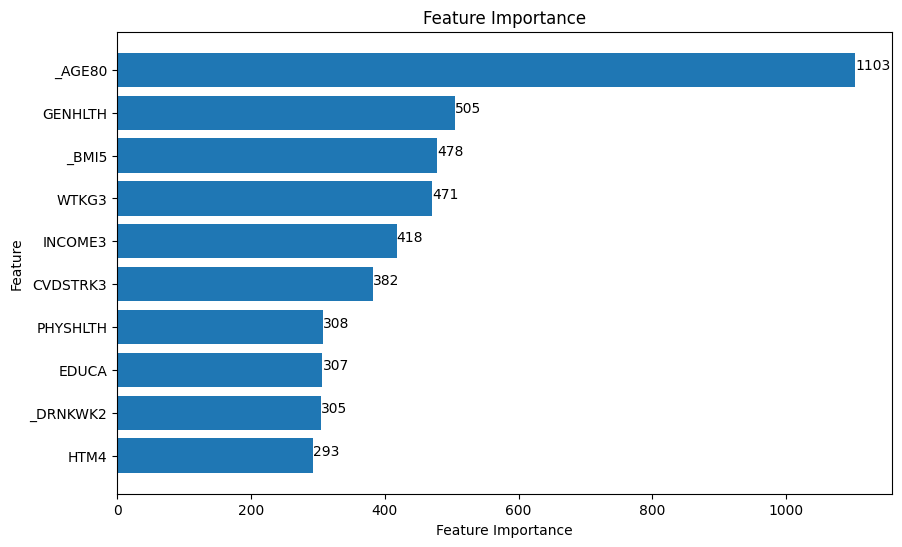

In [38]:
# Predict the test set using the best model
y_pred = random_search_lgb.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(
    pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = random_search_lgb.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{random_search_lgb.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{random_search_lgb.best_params_}")

# Print the best score
print(f"\n\nBest score:{random_search_lgb.best_score_}")

# Print the best index
print(f"\n\nBest index:{random_search_lgb.best_index_}")

# Print average score
print(f"\n\nBest average score:{random_search_lgb.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{random_search_lgb.cv_results_}")

# Plot Feature Importance
feature_importance = dict(
    zip(X.columns, random_search_lgb.best_estimator_.feature_importances_)
)

# Plot feature importance with feature importance values as data labels
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

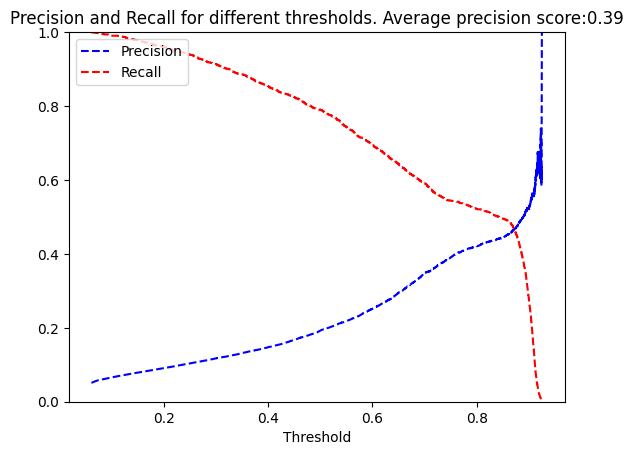

In [39]:
# Precision and Recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title(
    f"Precision and Recall for different thresholds. Average precision score:{average_precision_score(y_test, y_pred_prob):0.2f}"
)
plt.ylim([0, 1])
plt.show()

#### Specific LGBM Models


In [40]:
# Create a LGBM model
clf_lgb = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    n_estimators=280,
    reg_lambda=0.01,
    reg_alpha=0.1,
    min_child_weight=2,
    max_depth=45,
    learning_rate=0.01,
    colsample_bytree=0.8,
    subsample=0.7,
)

# Fit the grid search to the data
clf_lgb.fit(X_train, y_train)

# Predict the test set using the LGBM model
y_pred = clf_lgb.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(
    pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     35837
         1.0       0.19      0.79      0.31      1944

    accuracy                           0.82     37781
   macro avg       0.59      0.80      0.60     37781
weighted avg       0.95      0.82      0.87     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,29381,6456
Actual 1,409,1535


Accuracy: 0.8182949101400174
Precision: 0.1920911024903016
Recall: 0.7896090534979424


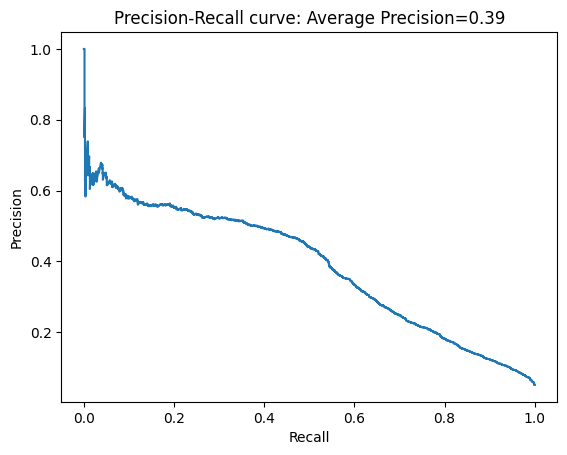

In [41]:
# Plot PR curve
y_pred_prob = clf_lgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve: Average Precision={average_precision:0.2f}")
plt.show()

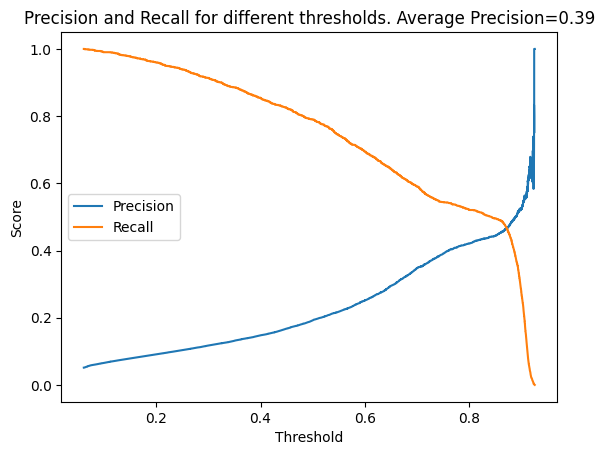

In [42]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(
    f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}"
)
plt.show()

In [43]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = thresholds.max()
    else:
        threshold = np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold:0.2f}, Precision: {precision_threshold:0.2f}, Recall: {recall_threshold:0.2f}"
    )

Threshold: 0.00, Precision: 0.05, Recall: 1.00
Threshold: 0.10, Precision: 0.07, Recall: 0.99
Threshold: 0.20, Precision: 0.09, Recall: 0.96
Threshold: 0.30, Precision: 0.12, Recall: 0.91
Threshold: 0.40, Precision: 0.15, Recall: 0.85
Threshold: 0.50, Precision: 0.19, Recall: 0.79
Threshold: 0.60, Precision: 0.25, Recall: 0.69
Threshold: 0.70, Precision: 0.35, Recall: 0.59
Threshold: 0.80, Precision: 0.42, Recall: 0.52
Threshold: 0.90, Precision: 0.53, Recall: 0.28
Threshold: 0.93, Precision: 1.00, Recall: 0.00


### Decision Tree Classifier

In [20]:
# Create the parameter grid
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=3)

# Instantiate the grid search model
grid_search_dt = GridSearchCV(estimator=dt_clf, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "precision")


grid_search_dt.fit(X_train, y_train)

score_df = pd.DataFrame(grid_search_dt.cv_results_)
print(score_df.head())
print(score_df.nlargest(5,"mean_test_score"))
dt_best = grid_search_dt.best_estimator_

# Make predictions
y_pred = dt_best.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print("Confusion matrix:")
display(
    pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           0.04          0.01             0.01            0.01   
1           0.05          0.01             0.01            0.00   
2           0.05          0.02             0.01            0.00   
3           0.04          0.00             0.01            0.01   
4           0.04          0.01             0.02            0.01   

  param_criterion  param_max_depth  param_min_samples_leaf  \
0            gini                2                       5   
1            gini                2                      10   
2            gini                2                      20   
3            gini                2                      50   
4            gini                2                     100   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 2, 'min_sam...               0.94   
1  {'criteri

,Predicted 0,Predicted 1
Actual 0,34570,1267
Actual 1,970,974


In [23]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

In [22]:
# Plot the decision tree
plt.figure(figsize=(120, 80))
plot_tree(dt_best, filled=True, feature_names=X.columns.tolist(), class_names=['Class 0', 'Class 1'])
# Save the plot as an image file
plt.savefig('decisiontree.png', dpi=300, bbox_inches='tight')
plt.show()

## Comparison of results from various models


In [24]:
clf_lr = LogisticRegression(C=1.0, max_iter=100, penalty="l2", solver="newton-cg")
clf_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features="sqrt",
    max_depth=50,
    bootstrap=True,
)
clf_xgb = XGBClassifier(
    reg_alpha=0.002,
    n_estimators=480,
    min_child_weight=1,
    max_depth=2,
    learning_rate=0.1,
    gamma=0.2,
    colsample_bytree=0.8,
)
clf_lgb = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    n_estimators=280,
    reg_lambda=0.01,
    reg_alpha=0.1,
    min_child_weight=2,
    max_depth=45,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=0.8,
    subsample=0.7,
)
clf_dt = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)


for clf in [clf_lr, clf_rf, clf_xgb, clf_lgb, clf_dt]:
    print(f"\n\nModel: {clf}")
    # Fit the grid search to the data
    clf.fit(X_train, y_train)

    # Predict the test set using the XGB model
    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("Confusion matrix:")
    display(
        pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            index=["Actual 0", "Actual 1"],
            columns=["Predicted 0", "Predicted 1"],
        )
    )
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))



Model: LogisticRegression(solver='newton-cg')
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,30141,5696
Actual 1,446,1498


Accuracy: 0.8374315131944629
Precision: 0.20822907978871283
Recall: 0.7705761316872428


Model: RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,28892,6945
Actual 1,377,1567


Accuracy: 0.8061988830364469
Precision: 0.18409304511278196
Recall: 0.8060699588477366


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=480, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,29648,6189
Actual 1,429,1515


Accuracy: 0.824832587808687
Precision: 0.19665109034267914
Recall: 0.779320987654321


Model: LGBMClassifier(colsample_bytree=0.8, gamma=0.1, learning_rate=0.01,
               max_depth=45, metric='binary_logloss', min_child_weight=2,
               n_estimators=280, objective='binary', reg_alpha=0.1,
               reg_lambda=0.01, subsample=0.7)
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[Li

,Predicted 0,Predicted 1
Actual 0,29381,6456
Actual 1,409,1535


Accuracy: 0.8182949101400174
Precision: 0.1920911024903016
Recall: 0.7896090534979424


Model: DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,34570,1267
Actual 1,970,974


Accuracy: 0.9407903443529817
Precision: 0.43462739848282017
Recall: 0.5010288065843621


## Save Models


In [45]:
# Save the model
joblib.dump(grid_search_lr.best_estimator_, "../models/lr_model.pkl")
joblib.dump(random_search_rf.best_estimator_, "../models/rf_model.pkl")
joblib.dump(random_search_xgb.best_estimator_, "../models/xgb_model.pkl")
joblib.dump(random_search_lgb.best_estimator_, "../models/lgbm_model.pkl")
joblib.dump(grid_search_dt.best_estimator_, "../models/dt_model.pkl")

['../models/lgbm_model.pkl']